# Area of Interest 3 (AOI3) Labeled Training Data, Exploratory Data Analysis

## Samuel Levin, samuel.levin@utdallas.edu

### Verify python interpreter (with necessary libraries installed), bulk import

In [1]:
import sys
sys.executable

'C:\\Users\\samle\\AppData\\Local\\ESRI\\conda\\envs\\arcgispro-pyre\\python.exe'

In [2]:
import arcpy
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pandas as pd
import seaborn as sns
import scipy

### Convert AOI3 labeled training data from vector polygons to integer raster
#### Maintain snapping and extent of AOI3 raster bands

In [3]:
arcpy.env.workspace = r'<PATH/TO/GDB>'

inflir_aoi3 = 'AOI3_FeatEng_flt_9'

inlabels_aoi3 = 'AOI3_Labels_vec'

In [4]:
arcpy.env.snapRaster = inflir_aoi3
arcpy.env.extent = inflir_aoi3
arcpy.env.cellSize = inflir_aoi3
arcpy.env.outputCoordinateSystem = arcpy.Describe(inflir_aoi3).spatialReference

In [5]:
outlabels = 'AOI3_Labels_rast'

arcpy.conversion.PolygonToRaster(inlabels_aoi3, "Classvalue", outlabels)

<Result 'C:\\Users\\samle\\Documents\\UT_Dallas\\2019_Spring\\GISC6317_GISProgrammingFundamentals\\FinalProject\\Levin_GISC6317Final.gdb\\AOI3_Labels_rast'>

#### Reclassify NoData as -1 for easier manipulation in NumPy

In [6]:
outlabels_reclass = arcpy.sa.Reclassify(outlabels, "Value", 
                                        "0 0;1 1;NODATA -1", "DATA"); 
outlabels_path = 'AOI3_Labels_v1_rast_reclass'
outlabels_reclass.save(outlabels_path)

In [7]:
labels = arcpy.RasterToNumPyArray(outlabels_path)
labels.shape

(802, 814)

In [8]:
labels

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int8)

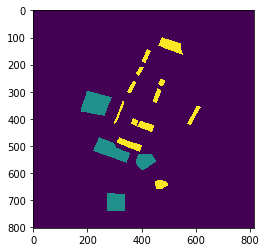

In [9]:
plt.imshow(labels)

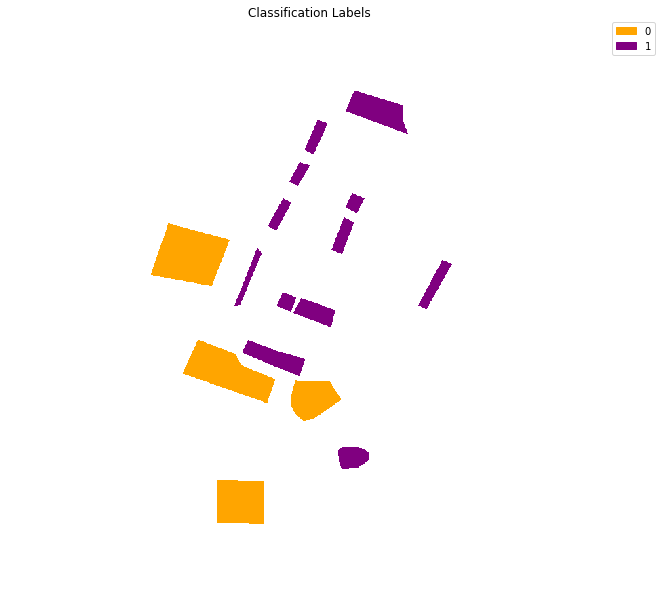

In [10]:
# https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
from matplotlib import colors
import matplotlib.patches as mpatches

mycmap = colors.ListedColormap(['white', 'orange', 'purple'])
bounds=[-1,0,1]
norm = colors.BoundaryNorm(bounds, mycmap.N)

plt.figure(figsize=(10,10))
plt.title('Classification Labels')
plt.axis('off')
im = plt.imshow(labels, cmap=mycmap)
values = np.unique(labels.ravel())
colors2 = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors2[i], label="{l}".format(l=values[i]) ) for i in range(len(values)) ][1:]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

In [11]:
elements, counts = np.unique(labels, return_counts=True)
print('{} labeled pixels'.format(counts[1] + counts[2]))
print('{} negative locations'.format(counts[1]))
print('{} positive locations'.format(counts[2]))

33978 labeled pixels
20679 negative locations
13299 positive locations


### Build boolean mask of labeled pixel locations

In [12]:
label_mask = np.logical_not(labels < 0)

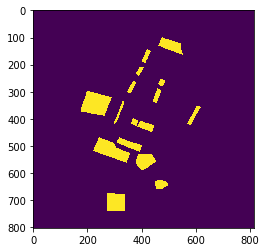

In [13]:
plt.imshow(label_mask)

In [14]:
aoi3 = arcpy.RasterToNumPyArray(inflir_aoi3, nodata_to_value=np.nan)
aoi3.shape

(9, 802, 814)

### Extract AOI3 engineered feature bands by labeled pixels mask

In [15]:
def extractByMask(band, mask):
    extract = np.copy(band)
    extract[mask==False] = np.nan
    return extract

In [16]:
aoi3_extract = np.array([extractByMask(aoi3[band], label_mask) for band in range(aoi3.shape[0])])
aoi3_extract.shape

(9, 802, 814)

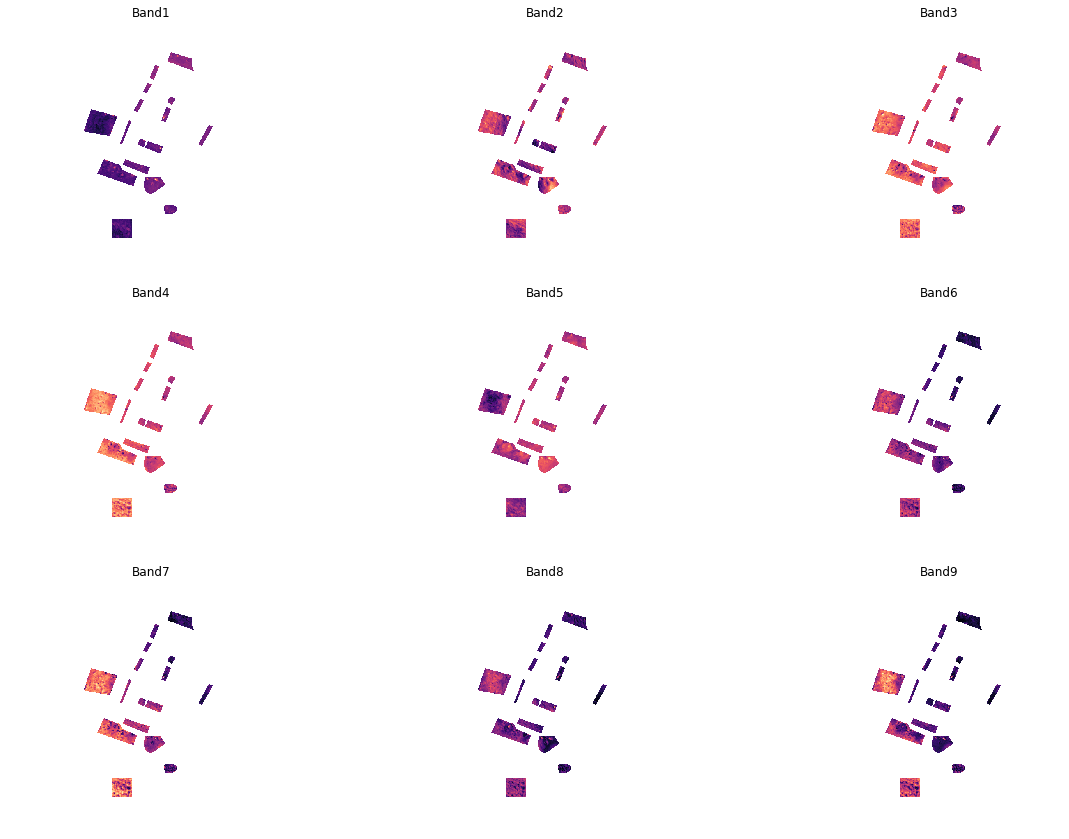

In [17]:
plt.figure(figsize=(20,30))
for band in range(aoi3_extract.shape[0]):
    plot = band+1
    col = 3
    row = 6
    
    plt.subplot(row, col, plot)
    plt.title('Band' + str(band+1))
    plt.axis('off')
    plt.imshow(aoi3_extract[band], cmap='magma')

### Create Pandas DataFrame for further exploration via pairwise plotting of each band
#### Flatten each band into a 1D array and remove null values

In [18]:
aoi3_extract_flat = np.array([aoi3_extract[band][label_mask].flatten() for band in range(aoi3_extract.shape[0])])
aoi3_extract_flat.shape

(9, 33978)

In [19]:
colnames = ['Flt0mm', 'Flt1mm', 'Flt2mm', 'Flt3mm', 'Flt4mm',
              'mmIDIbase', 'mmIDIbase_nf1', 'mmIDIprev', 'mmIDIprev_nf1']

dfdict = dict(zip(colnames, aoi3_extract_flat))

In [20]:
aoi3_extract_df = pd.DataFrame(dfdict)
aoi3_extract_df.head()

,Flt0mm,Flt1mm,Flt2mm,Flt3mm,Flt4mm,mmIDIbase,mmIDIbase_nf1,mmIDIprev,mmIDIprev_nf1
0,0.490975,0.401907,0.560122,0.574307,0.465574,0.086759,0.100875,0.192642,0.115028
1,0.498195,0.412807,0.569254,0.581864,0.475410,0.085125,0.100654,0.187450,0.113800
2,0.501805,0.404632,0.569254,0.579345,0.475410,0.087409,0.096975,0.195779,0.108335
3,0.483755,0.396458,0.576865,0.607053,0.504918,0.110152,0.136703,0.209290,0.136116
4,0.487365,0.388283,0.558600,0.591940,0.508197,0.098381,0.112136,0.201728,0.112659


In [21]:
labels[label_mask].shape

(33978,)

In [22]:
aoi3_extract_df['Label'] = labels[label_mask]
aoi3_extract_df['Label'] = aoi3_extract_df['Label'].apply(lambda x: 'Positive' if x==1 else 'Negative')

In [23]:
aoi3_extract_df.head()

,Flt0mm,Flt1mm,Flt2mm,Flt3mm,Flt4mm,mmIDIbase,mmIDIbase_nf1,mmIDIprev,mmIDIprev_nf1,Label
0,0.490975,0.401907,0.560122,0.574307,0.465574,0.086759,0.100875,0.192642,0.115028,Positive
1,0.498195,0.412807,0.569254,0.581864,0.475410,0.085125,0.100654,0.187450,0.113800,Positive
2,0.501805,0.404632,0.569254,0.579345,0.475410,0.087409,0.096975,0.195779,0.108335,Positive
3,0.483755,0.396458,0.576865,0.607053,0.504918,0.110152,0.136703,0.209290,0.136116,Positive
4,0.487365,0.388283,0.558600,0.591940,0.508197,0.098381,0.112136,0.201728,0.112659,Positive


In [24]:
aoi3_extract_df.describe()

,Flt0mm,Flt1mm,Flt2mm,Flt3mm,Flt4mm,mmIDIbase,mmIDIbase_nf1,mmIDIprev,mmIDIprev_nf1
count,33978.000000,33978.000000,33978.000000,33978.000000,33978.000000,33978.000000,33978.000000,33978.000000,33978.000000
mean,0.404076,0.398576,0.633368,0.690122,0.524008,0.285163,0.385540,0.320104,0.305607
std,0.067591,0.100502,0.094889,0.098210,0.097218,0.118697,0.166593,0.135659,0.177305
min,0.191336,0.049046,0.152207,0.209068,0.134426,0.006172,0.006808,0.014330,0.009149
25%,0.357401,0.329700,0.567732,0.617128,0.472131,0.187130,0.249773,0.211683,0.157280
50%,0.400722,0.404632,0.642314,0.680101,0.534426,0.293741,0.398026,0.316015,0.262253
75%,0.447653,0.467302,0.704718,0.773300,0.586885,0.374125,0.524344,0.418107,0.448311
max,0.935018,0.802452,0.968037,0.979849,0.983607,0.782705,0.793584,1.000000,0.831240


### Pairwise plotting of 9 feature bands, hue symbolized by label
#### Blue: Positive (1), Orange: Negative (0)

C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


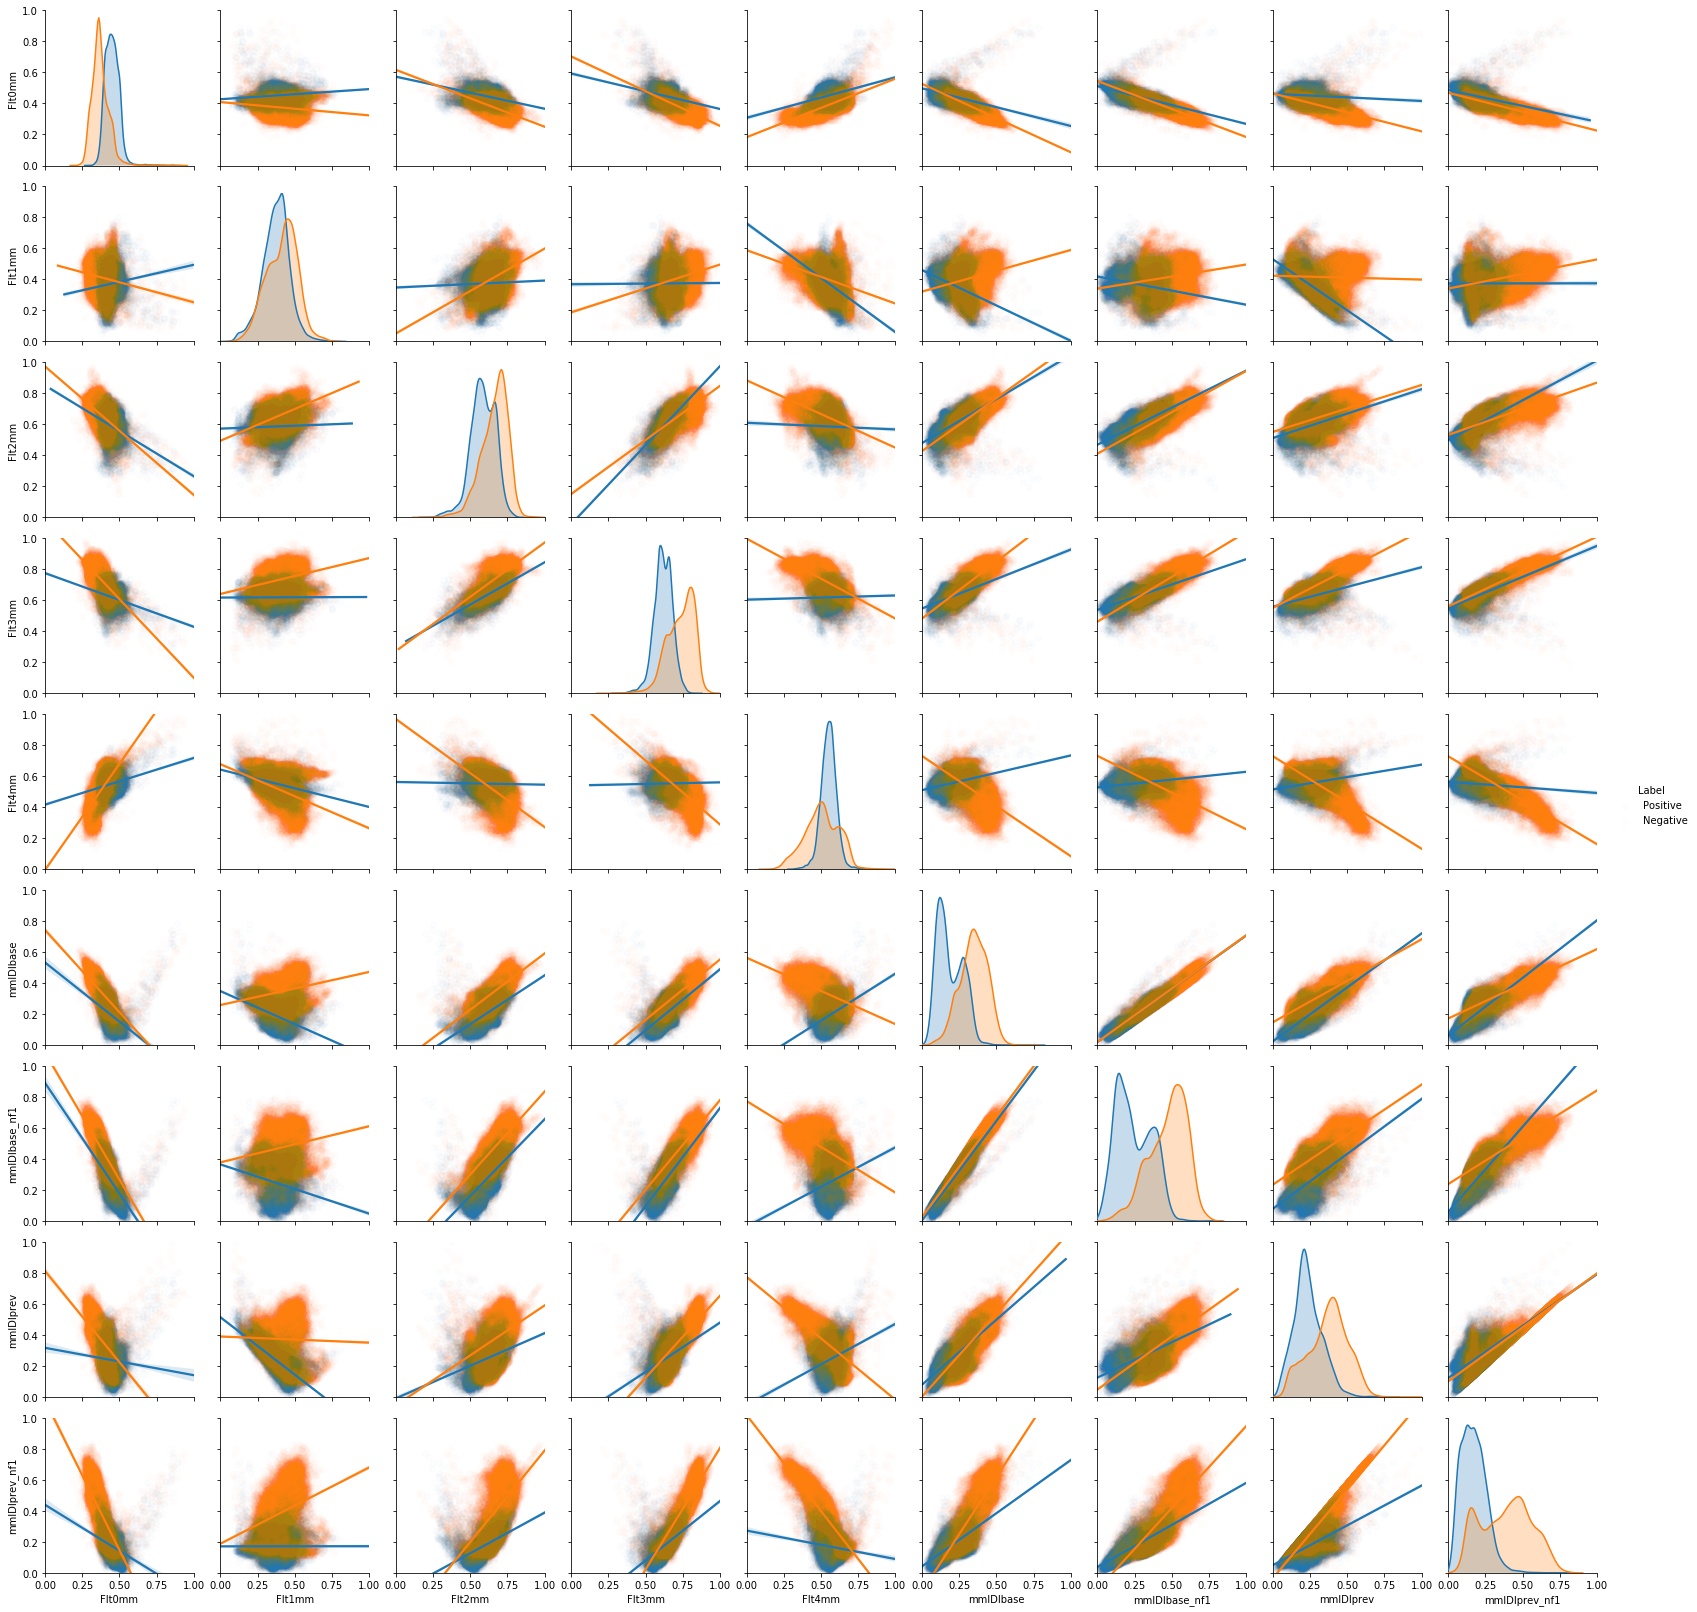

In [25]:
p = sns.pairplot(aoi3_extract_df, kind='reg', diag_kind="kde", markers='o', 
                 hue='Label',plot_kws={'scatter_kws': {'alpha': 0.01}})
for x in range(p.axes.shape[0]):
    for y in range(p.axes.shape[1]):
        p.axes[x,y].set_xlim(0,1)
        p.axes[x,y].set_ylim(0,1)
plt.show()

### Correlatation matrix of 9 feature bands by label

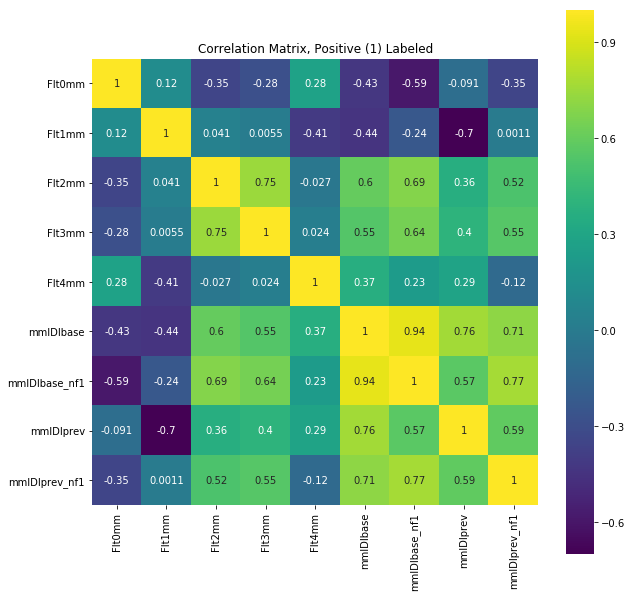

In [26]:
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix, Positive (1) Labeled')
sns.heatmap(aoi3_extract_df[aoi3_extract_df['Label']=='Positive'].corr(), annot=True, square=True, cmap='viridis')

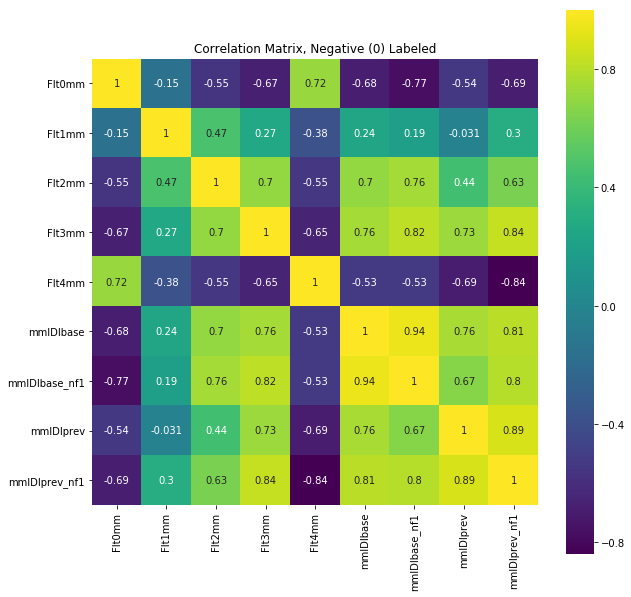

In [27]:
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix, Negative (0) Labeled')
sns.heatmap(aoi3_extract_df[aoi3_extract_df['Label']=='Negative'].corr(), annot=True, square=True, cmap='viridis')